# Poroelasticity

We consider quasi-static linear Biot-equations with an interface $\Gamma$ considered as thin heterogeneity with different permeability.

Find $\mathbf{u}, p, p_\Gamma$ s.t
\begin{align}
- \operatorname{div}( \mathbf{K} \nabla p ) &= 0, \quad \text{in } \Omega, \\
- \operatorname{div} \left( \sigma( \mathbf{u} ) - \alpha p I \right) &= 0, \quad \text{in } \Omega, \\
- \operatorname{div}( \mathbf{K}_\Gamma \nabla p_\Gamma ) &= q_\Gamma, \quad \text{in } \Gamma, \\
\end{align}
where
\begin{align}
\sigma( \mathbf{u} ) &= \lambda \operatorname{tr} \epsilon ( \mathbf{u} ) I + 2 \mu \epsilon( \mathbf{u} ), \\
\epsilon( \mathbf{u} ) &= \frac{1}{2} \left( \nabla \mathbf{u} + (\nabla \mathbf{u})^T \right) \\
\end{align}

and $\lambda, \mu > 0$ are the Lamé constants, $\alpha$ the Biot-Willis constant, $\mathbf{K}$, $\mathbf{K}_\Gamma$ bulk and interface permeability and $q_\Gamma$ a source term.

We impose interior boundary conditions
\begin{align}
p &= p_\Gamma, \\
\left( \sigma(\mathbf{u}) - \alpha p I \right) \cdot \mathbf{n} &= -p_\Gamma \mathbf{n}.
\end{align}
and consider a [T-junction](grids/tjunction.rst) as grid geometry.

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh

file = "grids/tjunction.msh"

gridView = mmesh((reader.gmsh, file), 2)
igridView = gridView.hierarchicalGrid.interfaceGrid

In [2]:
from ufl import *
from dune.ufl import Constant

lamb    = Constant( 1.2, name="lambda")
mu      = Constant( 0.8, name="mu")
alpha   = Constant(   1, name="alpha")
K       = as_matrix([[1e-4, 0], [0, 1e-6]])
K_g     = Constant(   1, name="K_g")
q       = Constant(1e-6, name="q")

epsilon = lambda u: 0.5 * (nabla_grad(u) + nabla_grad(u).T)
sigma   = lambda u: lamb * div(u) * Identity(2) + 2 * mu * epsilon(u)

In [3]:
from dune.fem.space import dglagrange

# Bulk
space = dglagrange(gridView, dimRange=3, order=1)

trial = TrialFunction(space)
test = TestFunction(space)

p,  ux,  uy  = split(trial)
pp, uux, uuy = split(test)

u  = as_vector([ux,  uy ])
uu = as_vector([uux, uuy])

x = SpatialCoordinate(space)
n = FacetNormal(space)
h = FacetArea(space)

left = conditional(x[0] < 1e-6, 1, 0)
right = conditional(x[0] > 1-1e-6, 1, 0)
bottom = conditional(x[1] < 1e-6, 1, 0)
top = conditional(x[1] > 1-1e-6, 1, 0)

solution = space.interpolate([0,0,0], name="solution")

# Interface
space_g = dglagrange(igridView, order=1)

p_g  = TrialFunction(space_g)
pp_g = TestFunction(space_g)

x_g = SpatialCoordinate(space_g)
n_g = FacetNormal(space_g)
h_g = FacetArea(space_g)

solution_g = space_g.interpolate(0, name="solution_g")

## Interior Penalty Discontinuous Galerkin (IPDG) Scheme

We implement a mixed-dimensional Interior Penalty Discontinuous Galerkin (IPDG) scheme which directly allows for a discontinuity along the interface. Including the penalty and consistency terms, we have the following weak form.

\begin{align*}
\renewcommand{\jump}[1]{[\mskip-5mu[ #1 ]\mskip-5mu]}
\renewcommand{\avg}[1]{\{\mskip-5mu\{ #1 \}\mskip-5mu\}}
\end{align*}

\begin{align}
A(\mathbf{u}, p; \mathbf{v}, \varphi) :=& \int_\Omega ( \mathbf{K} \nabla p ) \cdot \nabla \varphi~dx
- \int_\Omega q \varphi~dx \\
&+ \int_{\mathcal{F} \setminus \mathcal{F}_\Gamma} \frac{\beta}{h} \jump{p} \jump{\varphi}
- \avg{ \mathbf{K} \nabla p \cdot \mathbf{n} } \jump{\varphi}~dS
+ \int_{\mathcal{F}_D^p} \frac{\beta}{h} (p-p_D) \varphi - \mathbf{K} \nabla p \cdot \mathbf{n}\varphi~ds \\
&+ \int_{\mathcal{F}_\Gamma} \frac{\beta}{h} (p^+ - p_\Gamma) \varphi^+ - \mathbf{K} \nabla p^+ \cdot \mathbf{n}^+\varphi^+~dS \\
&+ \int_{\mathcal{F}_\Gamma} \frac{\beta}{h} (p^- - p_\Gamma) \varphi^- - \mathbf{K} \nabla p^- \cdot \mathbf{n}^-\varphi^-~dS \\
%
&+ \int_\Omega (\sigma(\mathbf{u}) - \alpha p I) : \epsilon(\mathbf{v})~dx
+ \int_{\mathcal{F} \setminus \mathcal{F}_\Gamma} \frac{\beta}{h} \jump{\mathbf{u}} \jump{\mathbf{v}} - ( \avg{ \sigma(\mathbf{u}) - \alpha p I } \cdot \mathbf{n}) \cdot \jump{\mathbf{v}}~dS \\
& + \int_{\mathcal{F}_D^u} \frac{\beta}{h} (\mathbf{u} - \mathbf{u}_D )\cdot \mathbf{v} - ( ( \sigma(\mathbf{u}) - \alpha p I ) \cdot \mathbf{n}) \cdot \mathbf{v}~ds \\
& - \int_{\mathcal{F}_\Gamma} - p_\Gamma (\mathbf{v}^+ \cdot \mathbf{n}^+) - p_\Gamma (\mathbf{v}^- \cdot \mathbf{n}^-)~dS \\
%
A_\Gamma(p_\Gamma; \varphi_\Gamma) :=&
\int_\Gamma (\mathbf{K}_\Gamma \nabla p_\Gamma) \cdot \nabla \varphi_\Gamma - q \varphi_\Gamma + \beta (p_\Gamma - \avg{p}) \varphi_\Gamma~dx \\
&+ \int_{\mathcal{F}^\Gamma} \frac{\beta}{h_\Gamma} \jump{p_\Gamma} \jump{\varphi_\Gamma}
- \avg{ \mathbf{K}_\Gamma \nabla p_\Gamma \cdot \mathbf{n}_\Gamma } \jump{\varphi_\Gamma}~dS
\end{align}

This weak form is implemented using UFL and Dune-MMesh's trace and skeleton functionality as follows.

In [4]:
from dune.mmesh import skeleton, trace, interfaceIndicator

I = interfaceIndicator(igridView)
beta = Constant(1e2, name="beta")

p_gamma = avg(skeleton(solution_g))
tracep = trace(solution)[0]


# Pressure
a  = inner(K * grad(p), grad(pp)) * dx
a -= q * pp * dx

a += beta / h * inner(jump(p), jump(pp)) * (1-I)*dS
a -= inner(avg(K * grad(p)), n('+')) * jump(pp) * (1-I)*dS

a += beta / h * (p - 0) * pp * (left+right) * ds
a -= inner(K * grad(p), n) * pp * (left+right) * ds


# Interface pressure
a_g  = inner(K_g * grad(p_g), grad(pp_g)) * dx
a_g -= q * pp_g * dx

a_g += beta / h_g * inner(jump(p_g), jump(pp_g)) * dS
a_g -= inner(avg(K_g * grad(p_g)), n_g('+')) * jump(pp_g) * dS


# Pressure is continuous at the interface
a += beta * (p('+') - p_gamma) * pp('+') * I*dS
a -= inner(K * grad(p('+')), n('+')) * pp('+') * I*dS

a += beta * (p('-') - p_gamma) * pp('-') * I*dS
a -= inner(K * grad(p('-')), n('-')) * pp('-') * I*dS

a_g += beta * (p_g - avg(tracep)) * pp_g * dx


# Displacement
sigma_p = lambda u, p: sigma(u) - alpha * p * Identity(2)
a += inner(sigma_p(u, p), epsilon(uu)) * dx

a += beta / h * inner(jump(u), jump(uu)) * (1-I)*dS
a -= dot(dot(avg(sigma_p(u, p)), n('+')), jump(uu)) * (1-I)*dS

a += beta / h * inner(u - as_vector([0,0]), uu) * (top+bottom) * ds
a -= dot(dot(sigma_p(u, p), n), uu) * (top+bottom) * ds


# Normal stress is -p at the interface
a -= -p_gamma * inner(uu('+'), n('+')) * I*dS
a -= -p_gamma * inner(uu('-'), n('-')) * I*dS

## Monolithic solution strategy

We use the `monolithicSolve` to obtain the solution of the strongly coupled mixed-dimensional system.

In [5]:
from dune.fem.scheme import galerkin
scheme   = galerkin([a   == 0], solver=("suitesparse", "umfpack"))
scheme_g = galerkin([a_g == 0], solver=("suitesparse", "umfpack"))

from dune.mmesh import monolithicSolve
converged = monolithicSolve(schemes=(scheme, scheme_g), targets=(solution, solution_g), verbose=True)

 i: 1  |Δx| = 1.19366078e+00  |f| = 1.72475757e-14
 i: 2  |Δx| = 5.35261373e-09  |f| = 9.79676418e-15


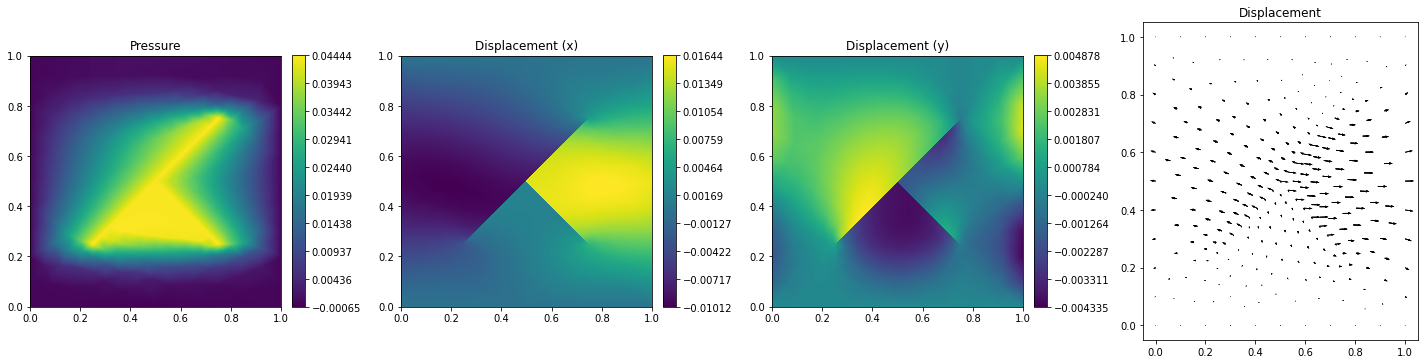

In [6]:
import matplotlib.pyplot as plt
from dune.fem.plotting import plotPointData as plot

fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs[0].set_title('Pressure')
plot(solution[0], figure=(fig, axs[0]), gridLines=None)
axs[1].set_title('Displacement (x)')
plot(solution[1], figure=(fig, axs[1]), gridLines=None)
axs[2].set_title('Displacement (y)')
plot(solution[2], figure=(fig, axs[2]), gridLines=None)
axs[3].set_title('Displacement')
plot(solution, vectors=[1,2], figure=(fig, axs[3]), gridLines=None)